In [0]:
import torch
import torch.nn as nn
import os
import random
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets 
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets
from torchvision.utils import save_image
import torch.utils.data

In [0]:
torch.cuda.is_available()

True

In [0]:
torch.cuda.get_device_name()

'Tesla P4'

In [0]:
CUDA = True
SEED = 1
BATCH_SIZE = 128
LOG_INTERVAL = 10
EPOCHS = 20
no_of_sample = 1

# connections through the autoencoder bottleneck
# in the pytorch VAE example, this is 2
ZDIMS = 2

torch.manual_seed(SEED)
if CUDA:
    torch.cuda.manual_seed(SEED)

# DataLoader instances will load tensors directly into GPU memory
kwargs = {'num_workers': 1, 'pin_memory': True} if CUDA else {}

#I have used MNIST dataset from Keras because on certain days of execution I faced certain difficulties using torchvision to download the MNIST dataset 
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()
x_train=torch.Tensor(x_train.astype('float32')/255).unsqueeze(1)
x_test=torch.Tensor(x_test.astype('float32')/255).unsqueeze(1)
train_loader=torch.utils.data.DataLoader(x_train,batch_size=BATCH_SIZE,shuffle=True,)
test_loader=torch.utils.data.DataLoader(x_test,batch_size=BATCH_SIZE,shuffle=False)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding=(1,1),stride=1)  # This padding keeps the size of the image same, i.e. same padding
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=(1,1), stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding=(1,1),stride=2)  # This padding keeps the size of the image same, i.e. same padding
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding=(1,1), stride=1)
        
        self.fc11 = nn.Linear(in_features=3136, out_features=1024)
        self.fc12 = nn.Linear(in_features=1024, out_features=ZDIMS)

        self.fc21 = nn.Linear(in_features=3136, out_features=1024)
        self.fc22 = nn.Linear(in_features=1024, out_features=ZDIMS)
        self.relu = nn.ReLU()

        # For decoder

        # For mu
        self.fc1 = nn.Linear(in_features=ZDIMS, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=3136)
        self.conv_t1 = nn.ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        self.conv_t2 = nn.ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        self.conv_t3 = nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv_t4 = nn.ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


    def encode(self, x: Variable) -> (Variable, Variable):

        x = x.view(-1, 1, 28, 28)
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = F.elu(self.conv4(x))
        x = x.view(-1, 3136)

        mu_z = F.elu(self.fc11(x))
        mu_z = self.fc12(mu_z)

        logvar_z = F.elu(self.fc21(x))
        logvar_z = self.fc22(logvar_z)

        return mu_z, logvar_z


    def reparameterize(self, mu: Variable, logvar: Variable) -> Variable:


        if self.training:
            sample_z = []
            for _ in range(no_of_sample):
                std = logvar.mul(0.5).exp_()  # type: Variable
                eps = Variable(std.data.new(std.size()).normal_())
                sample_z.append(eps.mul(std).add_(mu))

            return sample_z

        else:
           
            return mu

    def decode(self, z: Variable) -> Variable:

        x = F.elu(self.fc1(z))
        x = F.elu(self.fc2(x))
        x = x.view(-1, 64,7,7)
        x = F.relu(self.conv_t1(x))
        x = F.relu(self.conv_t2(x))
        x = F.relu(self.conv_t3(x))
        x = F.sigmoid(self.conv_t4(x))

        return x.view(-1, 784)


    def forward(self, x: Variable) -> (Variable, Variable, Variable):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        if self.training:
            return [self.decode(z) for z in z], mu, logvar
        else:
            return self.decode(z), mu, logvar
 

    def loss_function(self, recon_x, x, mu, logvar) -> Variable:
        # BCE loss checks how well the the model output matches our input

        if self.training:
            BCE = 0
            for recon_x_one in recon_x:
                BCE += F.binary_cross_entropy(recon_x_one, x.view(-1, 784))
            BCE /= len(recon_x)
        else:
            BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784))

        # KLD constrains the encoder output to a normal distribution
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # Normalise by same number of elements as in reconstruction
        KLD /= BATCH_SIZE * 784*10


     
        return BCE + KLD,BCE,KLD

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE()
model.to(device)




optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                              mode='min', factor=0.5,
                                              patience=2)




In [0]:
def train(epoch):
    # toggle model to train mode
    model.train()
    train_loss = 0
    b_loss=0
    k_loss=0
    # in the case of MNIST, len(train_loader.dataset) is 60000
    # each `data` is of BATCH_SIZE samples and has shape [128, 1, 28, 28]
    for batch_idx, (data) in enumerate(train_loader):
        data = Variable(data)
        data=data.to(device)
        optimizer.zero_grad()

        # push whole batch of data through VAE.forward() to get recon_loss
        recon_batch, mu, logvar = model(data)
        # calculate scalar loss
        loss,b,k = model.loss_function(recon_batch, data, mu, logvar)
        # calculate the gradient of the loss w.r.t. the graph leaves
        # i.e. input variables -- by the power of pytorch!
        loss.backward()
        train_loss += loss.item()
        b_loss += b.item()
        k_loss += k.item()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tBCE_Loss: {:.6f}\t\tKLD_Loss: {:.6f} '.format(epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader),
                       loss.item() / len(data),b.item()/len(data),k.item()/len(data)))

    print('====> Epoch: {} Average loss: {:.4f}\tavg_BCE_Loss: {:.4f}\tavg_KLD_Loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset),b_loss / len(train_loader.dataset),k_loss / len(train_loader.dataset)))

fint=[]
def test(epoch):
    model.eval()
    test_loss = 0

    # each data is of BATCH_SIZE (default 128) samples
    with torch.no_grad():
      for i, (data) in enumerate(test_loader):
          data=data.to(device)

          # we're only going to infer, so no autograd at all required: volatile=True
          data = Variable(data)
          recon_batch, mu, logvar = model(data)
          
          loss,_,_= model.loss_function(recon_batch, data, mu, logvar) # new line
          test_loss+=loss.item()   # new line
          if i == 0:
              n = min(data.size(0), 8)
              # for the first 128 batch of the epoch, show the first 8 input digits
              # with right below them the reconstructed output digits
              comparison = torch.cat([data[:n],
                                      recon_batch.view(BATCH_SIZE, 1, 28, 28)[:n]])
              save_image(comparison.data.cpu(),
                        './reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    torch.save(model.state_dict(), './model.pth')
    print("Learning Rate :{}".format(optimizer.param_groups[0]['lr']))
    fint.append(test_loss)
    scheduler.step(fint[-1])


if __name__ == "__main__":
    for epoch in range(1, EPOCHS + 1):
        train(epoch)
        test(epoch)

        # 64 sets of random ZDIMS-float vectors, i.e. 64 locations / MNIST
        # digits in latent space
        sample = Variable(torch.randn(64, ZDIMS))
        
        sample = sample.to(device)
        sample = model.decode(sample).cpu()

        # save out as an 8x8 matrix of MNIST digits
        # this will give you a visual idea of how well latent space can generate things
        # that look like digits
        save_image(sample.data.view(64, 1, 28, 28),'./reconstruction' + str(epoch) + '.png')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.005715	BCE_Loss: 0.005715		KLD_Loss: 0.000000 
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.002191	BCE_Loss: 0.002175		KLD_Loss: 0.000016 
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.002112	BCE_Loss: 0.002103		KLD_Loss: 0.000009 
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.001886	BCE_Loss: 0.001874		KLD_Loss: 0.000012 
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.001928	BCE_Loss: 0.001919		KLD_Loss: 0.000009 
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.001819	BCE_Loss: 0.001812		KLD_Loss: 0.000008 
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.001734	BCE_Loss: 0.001727		KLD_Loss: 0.000007 
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.001880	BCE_Loss: 0.001872		KLD_Loss: 0.000007 
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.001799	BCE_Loss: 0.001791		KLD_Loss: 0.000008 
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.001770	BCE_Loss: 0.001761		KLD_Loss: 0.000009 
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.001728	BCE_Loss: 0.001719		KLD_Loss: 0.000009 
Train Epoch: 1 [14080/6000

In [0]:
model.load_state_dict(torch.load('/content/model.pth' ))

<All keys matched successfully>

In [0]:
(_, _), (x_test, test_label) = mnist.load_data()
x_test=torch.Tensor(x_test.astype('float32')/255).unsqueeze(1)
test_loader=torch.utils.data.DataLoader(x_test,batch_size=BATCH_SIZE,shuffle=False)

In [0]:
pred=[]
pred2=[]
z_new=[]
with torch.no_grad():
      for i, (data) in enumerate(test_loader):
          data=data.to(device)


          data = Variable(data)
          mean, var = model.encode(data)
          z=model.reparameterize(mean,var)
          pred.extend(mean.detach().cpu().numpy())
          pred2.extend(var.detach().cpu().numpy())
          z_new.extend(z.detach().cpu().numpy())
        
pred=np.array(pred)
pred2=np.array(pred2)


# distribution of the means in a 2D space after encoding. All the data represented here belongs to the test dataset.
## Notice the seperation between digits and also a certain degree of overlap between similar digits.

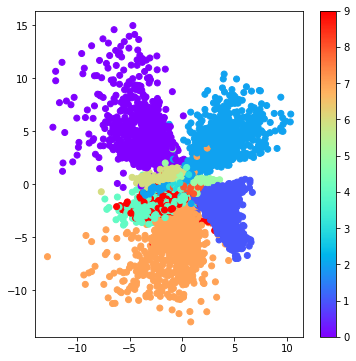

In [0]:
plt.figure(figsize=(6, 6))
plt.scatter(pred[:, 0], pred[:, 1], c=test_label,cmap='rainbow')
plt.colorbar()
plt.show()

# Newly generated digits not present in the MNIST dataset after sampling

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


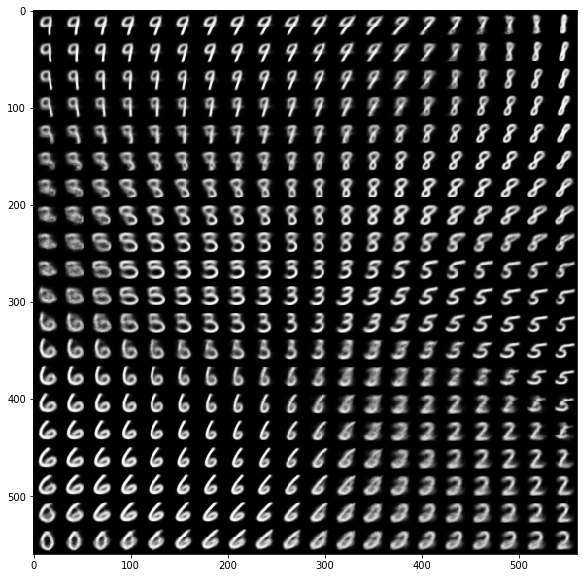

In [0]:
import numpy as np

from scipy.stats import norm

# Number of samples per latent space dimension
samples_per_dim = 20

# Size of plotted digits
digit_size = 28

# Sampling grid coordinates. Grid points density is
# proportial to density of latent variable prior.
grid_x = norm.ppf(np.linspace(0.05, 0.95, samples_per_dim))
grid_y = norm.ppf(np.linspace(0.05, 0.95, samples_per_dim))

figure = np.zeros((digit_size * samples_per_dim, 
                   digit_size * samples_per_dim))

for i, x in enumerate(grid_x):
    for j, y in enumerate(grid_y):
        t_ij = torch.Tensor(np.array([[x, y]]))
        t_ij = t_ij.to(device)
        x_ij =  model.decode(t_ij)
        digit = x_ij.detach().cpu().numpy().reshape(digit_size, digit_size)
        figure[j * digit_size: (j + 1) * digit_size,
               i * digit_size: (i + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r');

# reconstructed numbers .
## Certain numbers like 4 and 9 need to be worked on more

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


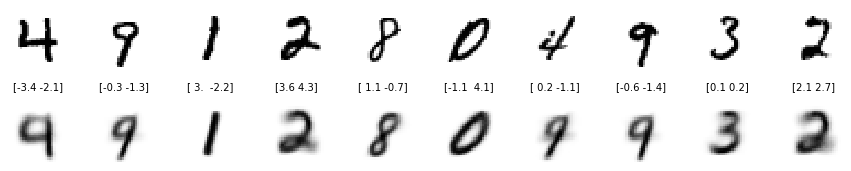

In [0]:
n_to_show = 10
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

mean, var = model.encode(example_images.to(device))
z_points=model.reparameterize(mean,var)


reconst_images = model.decode(z_points)

z_points=z_points.detach().cpu().numpy()
reconst_images=reconst_images.detach().cpu().numpy().reshape(-1,28,28)
fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')
    sub.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=sub.transAxes)
            
    sub.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img, cmap='gray_r')

# Distribution of 5000 points from the test dataset after encoding

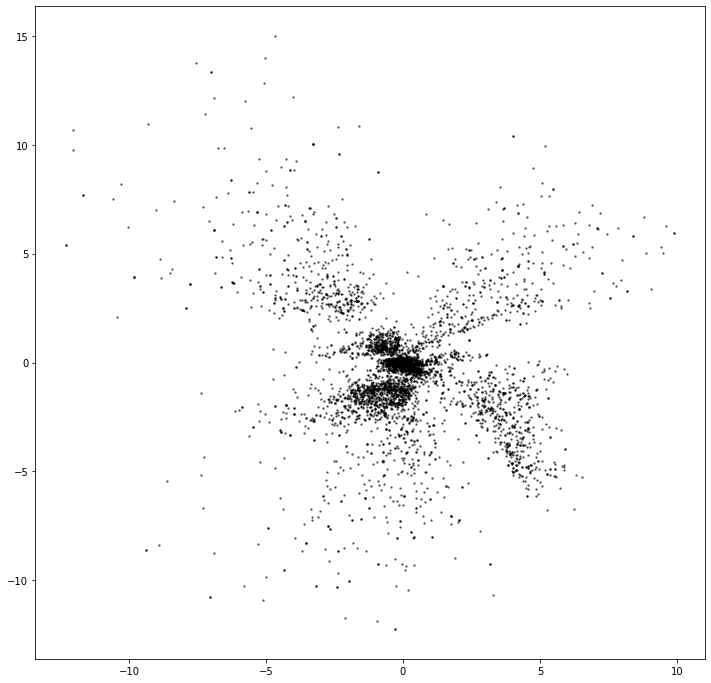

In [0]:
n_to_show = 5000
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = test_label[example_idx]

mean, var = model.encode(example_images.to(device))
z_points=model.reparameterize(mean,var)
z_points=z_points.detach().cpu().numpy()
min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
plt.show()

# Encoding of test data points on the left
# NOTE: our model does not have access to the labels yet is able to seperate deifferent labels by learning the distribution that seperates them.


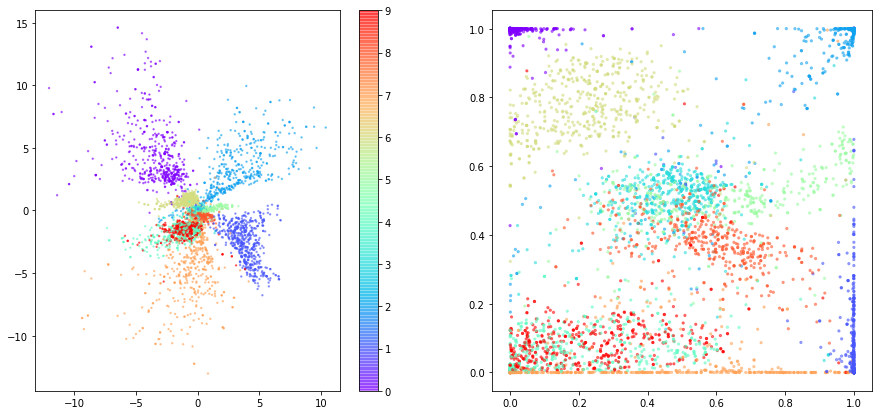

In [0]:
n_to_show = 5000
grid_size = 15
fig_height = 7
fig_width = 15

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = test_label[example_idx]

mean, var = model.encode(example_images.to(device))
z_points=model.reparameterize(mean,var)
z_points=z_points.detach().cpu().numpy()
p_points = norm.cdf(z_points)

fig = plt.figure(figsize=(fig_width, fig_height))

ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar(plot_1)

ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(p_points[:, 0] , p_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=5)



plt.show()